# Part 1: Bernoulli Mixture Model: Theory

To train a Bernoulli Mixture Model, the formulae are:

- Expectation step

$$z_{n, k} \leftarrow \frac{\pi_k \prod_{i = 1}^D \mu_{k, i}^{x_{n, i}} (1 - \mu_{k, i})^{1 - x_{n, i}} }{\sum_{m = 1}^K \pi_m \prod_{i = 1}^D \mu_{m, i}^{x_{n, i}} (1 - \mu_{m, i})^{1 - x_{n, i}}}$$

- Maximization step

$$\mathbf{\mu_m} \leftarrow \mathbf{\bar{x}_m}$$

$$\pi_m \leftarrow \frac{N_m}{N}$$

where $\mathbf{\bar{x}_m} = \frac{1}{N_m} \sum_{n = 1}^N z_{n, m} \mathbf{x_n}$ and $N_m = \sum_{n = 1}^N z_{n, m}$

# Part 2: BMM Implementation

**(1)** see `bmm.py` for the complete implementation of the BMM

the source code of this project is available at https://github.com/toogy/mnist-em-bmm-gmm

In [5]:
# settings

data_path = '/home/data/ml/mnist'
k = 10

In [13]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy

import bmm
import classifier

In [7]:
# loading the data
from mnist import load_mnist

data, labels = load_mnist(dataset='training', path=data_path)

# pre-processing the data (reshape + making it binary)

data = np.reshape(data, (60000, 784))
data = np.where(data > 0.5, 1, 0)

In [8]:
# creating our model
model = bmm.bmm(k, verbose=True)

In [5]:
model.fit(data)

[01] likelihood = -165.43042977139558 (elapsed 0:00:00.000034)
[02] likelihood = -165.02957455724035 (elapsed 0:00:04.156770)
[03] likelihood = -164.93493257314412 (elapsed 0:00:08.267053)
[04] likelihood = -164.8928031105364 (elapsed 0:00:12.341825)
[05] likelihood = -164.87174228841914 (elapsed 0:00:16.384710)
[06] likelihood = -164.8599233783288 (elapsed 0:00:20.436325)
[07] likelihood = -164.8525684868083 (elapsed 0:00:24.482114)
[08] likelihood = -164.84795446767671 (elapsed 0:00:28.525073)
[09] likelihood = -164.84471827401373 (elapsed 0:00:32.550115)
[10] likelihood = -164.8425623860822 (elapsed 0:00:36.545103)
[11] likelihood = -164.84120668107724 (elapsed 0:00:40.626287)
[12] likelihood = -164.84009537213777 (elapsed 0:00:44.801600)
[13] likelihood = -164.83896672156143 (elapsed 0:00:48.931067)
[14] likelihood = -164.83829375279507 (elapsed 0:00:52.987908)
converged in 14 iterations in 0:00:56.808847


**(2)** Plot of the means $\mathbf{\mu}$ of the learnt mixture

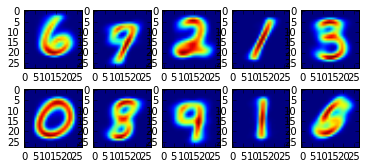

In [6]:
model.plot_means()

**(3)** It is not possible to have one center per class with only 10 components even though there are only 10 different digits. Multiple components can represent the same digits (as we can see from the plot). When this happens, it is not possible to represent all of them with only 10 components.

It is possible to avoid this by initializing each component's $\mu_k$ to the mean of the corresponding digit calculated from the labelized dataset. But then it becomes **supervised** learning, which is not what we want.

Here is the result with this kind of initialization:

In [9]:
model = bmm.bmm(10)
model.fit(data, init_heuristic='data_classes_mean', labels=labels)

converged in 39 iterations in 0:02:54.756242


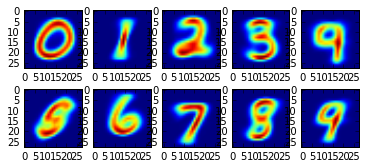

In [11]:
model.plot_means()

**(4)** For each label we select the subset of the data that corresponds to this label and train a `bmm` to represent the corresponding class. We then have 10 `bmm` which, together, form a digit classifier.

In [16]:
# number of components for each BMM
k = 7

bayesian_classifier = classifier.classifier(k)

bayesian_classifier.fit(data, labels)

training label 0 (5923 samples)
converged in 100 iterations in 0:00:24.623451
training label 1 (6742 samples)
converged in 52 iterations in 0:00:13.955055
training label 2 (5958 samples)
converged in 82 iterations in 0:00:20.009943
training label 3 (6131 samples)
converged in 30 iterations in 0:00:07.248438
training label 4 (5842 samples)
converged in 45 iterations in 0:00:11.279636
training label 5 (5421 samples)
converged in 85 iterations in 0:00:18.799659
training label 6 (5918 samples)
converged in 31 iterations in 0:00:07.241881
training label 7 (6265 samples)
converged in 49 iterations in 0:00:12.853336
training label 8 (5851 samples)
converged in 27 iterations in 0:00:06.931870
training label 9 (5949 samples)
converged in 29 iterations in 0:00:07.326120


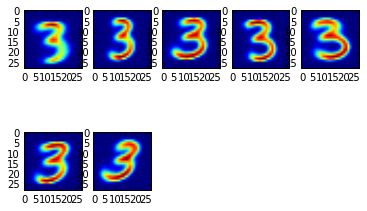

In [17]:
bayesian_classifier.models[3].plot_means()

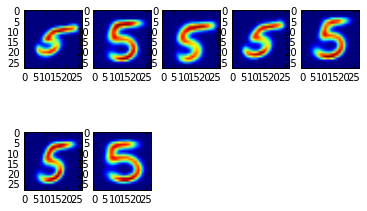

In [18]:
bayesian_classifier.models[5].plot_means()

In [20]:
test_data, test_labels = load_mnist(dataset='testing', path=data_path)
test_data = np.reshape(test_data, (test_data.shape[0], 784))
test_data = np.where(test_data > 0.5, 1, 0)

label_set = set(labels)

predicted_labels = bayesian_classifier.predict(test_data, label_set)

print('accuracy: {}'.format(np.mean(predicted_labels == test_labels)))

accuracy: 0.9242


# Part 3: Gaussian Mixture Models

BMM are adapted to binary images because they work with 0s and 1s. MNIST data initially was in the range $[0, 255]$. By binarizing the images, information is lost when it could make the model more accurate. GMM can work with real numbers and perform better than BMM for classifying digits.

The Gaussian mixture distribution can be written as a linear superposition of Gaussians in the form

$$p(\mathbf{x}) = \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x}|\mathbf{\mu}_k, \mathbf{\Sigma}_k)$$